# Combining the power of PyTorch and NiftyNet

## Contents

1. [Introduction](#Introduction)
2. [Running the notebook](#Running-the-notebook)
3. [Setup](#Setup)
4. [Transferring parameters from NiftyNet to PyTorch](#Transferring-parameters-from-NiftyNet-to-PyTorch)
5. [Testing the model](#Testing-the-model)
6. [Conclusion](#Conclusion)
7. [Acknowledgments](#Acknowledgments)



## Introduction

NiftyNet is "[an open source convolutional neural networks platform for medical image analysis and image-guided therapy](https://niftynet.io/)" built on top of [TensorFlow](https://www.tensorflow.org/). Due to its available implementations of successful architectures, patch-based sampling and straightforward configuration, it has become a [popular choice](https://github.com/NifTK/NiftyNet/network/members) to get started with deep learning in medical imaging.

PyTorch is "[an open source deep learning platform that provides a seamless path from research prototyping to production deployment](https://pytorch.org/)". It is low-level enough to offer a lot of control over what is going on under the hood during training, and its [dynamic computational graph](https://medium.com/intuitionmachine/pytorch-dynamic-computational-graphs-and-modular-deep-learning-7e7f89f18d1) allows for easy debugging. Being a generic deep learning framework, it is not tailored to the needs of the medical imaging field, although its popularity in this field is increasing rapidly.

One can [extend a NiftyNet application](https://niftynet.readthedocs.io/en/dev/extending_app.html), but it is not straightforward without being familiar with the framework and fluent in TensorFlow 1.X. Therefore it can be convenient to implement applications in PyTorch using NiftyNet models and functionalities. In particular, combining both frameworks allows for fast architecture experimentation and transfer learning.

So why not use [both](https://www.youtube.com/watch?v=vqgSO8_cRio&feature=youtu.be&t=5)? In this tutorial we will port the parameters of a model trained on NiftyNet to a PyTorch model and compare the results of running an inference using both frameworks.

### Image segmentation

Although NiftyNet supports different applications, it is mostly used for medical image segmentation.

***Image segmentation using deep learning*** were the 5 most common words in all full paper titles from *both* [MICCAI 2018](https://www.miccai2018.org/en/) and [MIDL 2019](https://2019.midl.io/), which shows the interest of the medical imaging community in the topic.

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">&quot;Image segmentation using deep learning&quot;, guess this is the hottest topic in MIDL <a href="https://twitter.com/hashtag/MIDL2019?src=hash&amp;ref_src=twsrc%5Etfw">#MIDL2019</a> <a href="https://twitter.com/midl_conference?ref_src=twsrc%5Etfw">@midl_conference</a> <a href="https://t.co/64smdMjnxY">pic.twitter.com/64smdMjnxY</a></p>&mdash; Hua Ma (@forever_pippo) <a href="https://twitter.com/forever_pippo/status/1148329951550197760?ref_src=twsrc%5Etfw">July 8, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Just like <a href="https://twitter.com/hashtag/miccai2018?src=hash&amp;ref_src=twsrc%5Etfw">#miccai2018</a>! <a href="https://t.co/3ZTHxj9iPT">pic.twitter.com/3ZTHxj9iPT</a></p>&mdash; Julia Schnabel (@ja_schnabel) <a href="https://twitter.com/ja_schnabel/status/1148356705916526592?ref_src=twsrc%5Etfw">July 8, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

### HighRes3DNet

<img src="https://niftynet.io/img/niftynet-logo.png" alt="drawing" width="150"/>

HighRes3DNet is a residual convolutional neural network architecture designed to have a large receptive field and preserve a high resolution using a relatively small number of parameters. It was presented in 2017 by Li et al. at IPMI: [*On the Compactness, Efficiency, and Representation of 3D Convolutional Networks: Brain Parcellation as a Pretext Task*](https://arxiv.org/abs/1707.01992).

<img src="https://github.com/fepegar/tf2pt/raw/master/images/network.png" alt="HighRes3DNet" width="600"/>

The authors used NiftyNet to implement and train a model based on this architecture to perform [brain parcellation](https://ieeexplore.ieee.org/document/7086081?arnumber=7086081) using $T_1$-weighted MR images from the [ADNI dataset](http://adni.loni.usc.edu/). they achieved competitive segmentation performance compared with state-of-the-art architectures such as [DeepMedic](https://biomedia.doc.ic.ac.uk/software/deepmedic/) or [U-Net](https://arxiv.org/abs/1606.06650).

This figure from the paper shows a parcellation produced by HighRes3DNet:

<img src="https://github.com/fepegar/tf2pt/raw/master/images/li-000.png" alt="Input MRI"/>
<img src="https://github.com/fepegar/tf2pt/raw/master/images/li-001.png" alt="Output parcellation"/>





The code of the architecture is on [NiftyNet GitHub repository](https://github.com/NifTK/NiftyNet/blob/dev/niftynet/network/highres3dnet.py). The authors have uploaded the parameters and configuration file to the [Model Zoo](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs/highres3dnet_brain_parcellation).

After reading the paper and the code, it is relatively straightforward to [implement the same architecture using PyTorch](https://github.com/fepegar/highresnet).

## Running the notebook

All the code is hosted in a GitHub repository:
[`fepegar/miccai-educational-challenge-2019`](https://github.com/fepegar/miccai-educational-challenge-2019).

The latest release can also be found on the Zenodo repository under this DOI: [10.5281/zenodo.3352316](https://doi.org/10.5281/zenodo.3352316).

### Online

If you have a Google account, the best way to run this notebook seamlessly is using [Google Colab](https://colab.research.google.com/drive/1vqDojKuC4Svb97LdoEyZQygm3jccX4hr). You will need to click on "Open in playground", at the top left:

![Playground mode screenshot](https://github.com/fepegar/miccai-educational-challenge-2019/raw/master/images/playground.png)

You will also get a couple of warnings that you can safely ignore. The first one warns about this notebook not being authored by Google and the second one asks for confirmation to reset all runtimes. These are valid points, but will not affect this tutorial.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1vqDojKuC4Svb97LdoEyZQygm3jccX4hr)

---

Please [report any issues on GitHub](https://github.com/fepegar/miccai-educational-challenge-2019/issues/new) and I will fix them. You can also [drop me an email](mailto:fernando.perez.garcia.17@ucl.ac.uk?subject=Combining%20the%20power%20of%20PyTorch%20and%20NiftyNet) if you have any questions or comments.



### Locally

To write this notebook I used Ubuntu 18.04 installed on an Alienware 13 R3 laptop, which includes a 6-GB GeForce GTX 1060 NVIDIA GPU. I am using CUDA 9.0.

Inference using PyTorch took 5725 MB of GPU memory. TensorFlow usually takes as much as possible beforehand.

To run this notebook locally, I recommend downloading the repository and creating a [`conda`](https://docs.conda.io/en/latest/miniconda.html) environment:

```shell
git clone https://github.com/fepegar/miccai-educational-challenge-2019.git
cd miccai-educational-challenge-2019
conda create -n mec2019 python=3.6 -y
conda activate mec2019 && conda install jupyterlab -y && jupyter lab
```

### nbviewer

An already executed version of the notebook can be rendered using [nbviewer](https://nbviewer.jupyter.org/github/fepegar/miccai-educational-challenge-2019/blob/master/Combining_the_power_of_PyTorch_and_NiftyNet.ipynb?flush_cache=true).

<a href="https://nbviewer.jupyter.org/github/fepegar/miccai-educational-challenge-2019/blob/master/Combining_the_power_of_PyTorch_and_NiftyNet.ipynb?flush_cache=true" 
   target="_parent">
   <img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.png" 
      width="109" height="20">
</a>

### Interactive volume plots

If you run the notebook, you can use interactive plots to navigate through the volume slices by setting this variable to `True`. You might need to run the volume visualization cells individually after running the whole notebook. This feature is experimental and therefore disabled by default.

In [0]:
interactive_plots = False

## Setup

### Install and import libraries

Clone NiftyNet and some custom Python libraries for this notebook. This might take around one minute.

In [0]:
%%capture --no-stderr
# This might take about 30 seconds
!rm -rf NiftyNet && git clone https://github.com/NifTK/NiftyNet --depth 1
!cd NiftyNet && git checkout df0f86733357fdc92bbc191c8fec0dcf49aa5499 && cd ..
!pip install -r NiftyNet/requirements-gpu.txt
!curl -O https://raw.githubusercontent.com/fepegar/miccai-educational-challenge-2019/master/requirements.txt
!curl -O https://raw.githubusercontent.com/fepegar/miccai-educational-challenge-2019/master/tf2pt.py
!curl -O https://raw.githubusercontent.com/fepegar/miccai-educational-challenge-2019/master/utils.py
!curl -O https://raw.githubusercontent.com/fepegar/miccai-educational-challenge-2019/master/visualization.py
!curl -O https://raw.githubusercontent.com/fepegar/miccai-educational-challenge-2019/master/highresnet_mapping.py
!curl -O https://raw.githubusercontent.com/fepegar/highresnet/master/GIFNiftyNet.ctbl
!pip install -r requirements.txt
!pip install --upgrade numpy
!pip install ipywidgets
import sys
sys.path.insert(0, 'NiftyNet')

In [0]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os
import tempfile
from pathlib import Path
from configparser import ConfigParser

import numpy as np
import pandas as pd

try:
    # Fancy rendering of Pandas tables
    import google.colab.data_table
    %load_ext google.colab.data_table
    print("We are on Google Colab")
except ModuleNotFoundError:
    print("We are not on Google Colab")
    pd.set_option('display.max_colwidth', -1)  # do not truncate strings when displaying data frames
    pd.set_option('display.max_rows', None)    # show all rows

import torch

from highresnet import HighRes3DNet

We are on Google Colab


In [0]:
%%capture
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tf2pt
import utils
import visualization
import highresnet_mapping

if interactive_plots:  # for Colab or Jupyter
    plot_volume = visualization.plot_volume_interactive
else:  # for HTML, GitHub or nbviewer
    plot_volume = visualization.plot_volume

from niftynet.io.image_reader import ImageReader
from niftynet.engine.sampler_grid_v2 import GridSampler
from niftynet.engine.windows_aggregator_grid import GridSamplesAggregator
from niftynet.layer.pad import PadLayer
from niftynet.layer.binary_masking import BinaryMaskingLayer
from niftynet.layer.histogram_normalisation import HistogramNormalisationLayer
from niftynet.layer.mean_variance_normalisation import MeanVarNormalisationLayer

### Download NiftyNet model and test data

We can use NiftyNet's `net_download` to get all we need from the [Model Zoo entry](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs/highres3dnet_brain_parcellation#downloading-model-zoo-files) corresponding to brain parcellation using HighRes3DNet:

In [0]:
%%capture
%run NiftyNet/net_download.py highres3dnet_brain_parcellation_model_zoo

In [0]:
niftynet_dir = Path('~/niftynet').expanduser()
utils.list_files(niftynet_dir)

niftynet/
    data/
        OASIS/
            license
            OAS1_0145_MR2_mpr_n4_anon_sbj_111.nii.gz
    extensions/
        __init__.py
        highres3dnet_brain_parcellation/
            highres3dnet_config_eval.ini
            __init__.py
        network/
            __init__.py
    models/
        highres3dnet_brain_parcellation/
            Modality0.csv
            settings_inference.txt
            inference_niftynet_log
            databrain_std_hist_models_otsu.txt
            logs/
            parcellation_output/
                inferred.csv
                window_seg_OAS1_0145_MR2_mpr_n4_anon_sbj_111__niftynet_out.nii.gz
            models/
                model.ckpt-33000.data-00000-of-00001
                model.ckpt-33000.meta
                model.ckpt-33000.index


There are three directories under `~/niftynet`:
1. `extensions` is a Python package that contains the [configuration file].(https://niftynet.readthedocs.io/en/dev/config_spec.html)
2. `models` contains the landmarks for [histogram standardization](https://ieeexplore.ieee.org/document/836373) (an MRI preprocessing step) and the network parameters.
3. `data` contains an [OASIS](https://www.oasis-brains.org/) MRI sample that can be used to test the model.

Here are the paths to the downloaded files and to the files that will be generated by the notebook. I use `nn` for NiftyNet, `tf` for TensorFlow and `pt` for PyTorch.

In [0]:
models_dir = niftynet_dir / 'models'
zoo_entry = 'highres3dnet_brain_parcellation'
input_checkpoint_tf_name = 'model.ckpt-33000'
input_checkpoint_tf_path = models_dir / zoo_entry / 'models' / input_checkpoint_tf_name
data_dir = niftynet_dir / 'data' / 'OASIS'
config_path = niftynet_dir / 'extensions' / zoo_entry / 'highres3dnet_config_eval.ini'
histogram_landmarks_path = models_dir / zoo_entry / 'databrain_std_hist_models_otsu.txt'
tempdir = Path(tempfile.gettempdir()) / 'miccai_niftynet_pytorch'
tempdir.mkdir(exist_ok=True)
output_csv_tf_path = tempdir / 'variables_tf.csv'
output_state_dict_tf_path = tempdir / 'state_dict_tf.pth'
output_state_dict_pt_path = tempdir / 'state_dict_pt.pth'
prediction_pt_dir = tempdir / 'prediction'
prediction_pt_dir.mkdir(exist_ok=True)
color_table_path = 'GIFNiftyNet.ctbl'

Note that the path to the checkpoint is not a path to an existing filename, but the basename of the three checkpoint files.

## Transferring parameters from NiftyNet to PyTorch

### Variables in TensorFlow world 

<img src="https://static.nvidiagrid.net/ngc/containers/tensorflow.png" alt="drawing" width="50"/>

There are two modules that are relevant for this section in the
[repository](https://github.com/fepegar/miccai-educational-challenge-2019).
[`tf2pt`](https://github.com/fepegar/miccai-educational-challenge-2019/blob/master/tf2pt.py) contains generic functions that can be used to transform any TensorFlow model to PyTorch.
[`highresnet_mapping`](https://github.com/fepegar/miccai-educational-challenge-2019/blob/master/highresnet_mapping.py) contains custom functions that are specific for HighRes3DNet.

Let's see what variables are stored in the checkpoint.

These are filtered out by
[`highresnet_mapping.is_not_valid()`](https://github.com/fepegar/miccai-educational-challenge-2019/blob/c96777d654ac577c0dba218038f76c2497de946a/highresnet_mapping.py#L4-L11)
for clarity:
* Variables used by the Adam optimizer during training
* Variables with no shape. They won't help much.
* Variables containing `biased` or `ExponentialMovingAverage`. I have experimented with them and the results using these variables turned out to be different to the ones generated by NiftyNet.

We will store the variables names in a data frame to list them in this notebook and the values in a Python dictionary to retrieve them later. I figured out the code in
[`tf2pt.checkpoint_tf_to_state_dict_tf()`](https://github.com/fepegar/miccai-educational-challenge-2019/blob/c96777d654ac577c0dba218038f76c2497de946a/tf2pt.py#L90-L129)
reading the corresponding [TensorFlow docs](https://www.tensorflow.org/api_docs/python/tf/train/list_variables) and [Stack Overflow answers](https://stackoverflow.com/search?q=restore+tensorflow).

In [0]:
# %%capture
tf2pt.checkpoint_tf_to_state_dict_tf(
    input_checkpoint_tf_path=input_checkpoint_tf_path,
    output_csv_tf_path=output_csv_tf_path,
    output_state_dict_tf_path=output_state_dict_tf_path,
    filter_out_function=highresnet_mapping.is_not_valid,
    replace_string='HighRes3DNet/',
)
data_frame_tf = pd.read_csv(output_csv_tf_path)
state_dict_tf = torch.load(output_state_dict_tf_path)

W0813 14:24:09.451148 140069650646912 deprecation_wrapper.py:119] From /content/tf2pt.py:106: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0813 14:24:09.465713 140069650646912 deprecation_wrapper.py:119] From /content/tf2pt.py:114: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0813 14:24:10.389280 140069650646912 deprecation_wrapper.py:119] From /content/tf2pt.py:122: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0813 14:24:10.484770 140069650646912 deprecation_wrapper.py:119] From /content/tf2pt.py:124: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

I0813 14:24:14.702649 140069650646912 saver.py:1280] Restoring parameters from /root/niftynet/models/highres3dnet_brain_parcellation/models/model.ckpt-33000


In [0]:
data_frame_tf

,Unnamed: 0,name,shape
0,0,conv_0_bn_relu/bn_/beta,16
1,1,conv_0_bn_relu/bn_/gamma,16
2,2,conv_0_bn_relu/bn_/moving_mean,16
3,3,conv_0_bn_relu/bn_/moving_variance,16
4,4,conv_0_bn_relu/conv_/w,"3, 3, 3, 1, 16"
5,5,conv_1_bn_relu/bn_/beta,80
6,6,conv_1_bn_relu/bn_/gamma,80
7,7,conv_1_bn_relu/bn_/moving_mean,80
8,8,conv_1_bn_relu/bn_/moving_variance,80
9,9,conv_1_bn_relu/conv_/w,"1, 1, 1, 64, 80"


The weight parameters associated with each convolutional layer, denoted with `conv_/w`, are stored with shape representing the three spatial dimensions, the input channels and the output channels: $(Depth, Height, Width, Channels_{in}, Channels_{out})$. Calling the spatial dimensions *depth*, *height* and *width* does not make a lot of sense when dealing with 3D medical images, but we will keep this computer vision terminology as it is consistent with the documentation of both PyTorch and TensorFlow.

The layer names and parameter shapes are coherent overall with the figure in the HighRes3DNet paper, but there is an additional $1 \times 1 \times 1$ convolutional layer with 80 output channels, which is also in the [code](https://github.com/NifTK/NiftyNet/blob/1832a516c909b67d0d9618acbd04a7642c12efca/niftynet/network/highres3dnet.py#L93). It seems to be the model with [dropout](http://jmlr.org/papers/v15/srivastava14a.html) from the paper that achieved the highest performance, so [our implementation of the architecture](https://github.com/fepegar/highresnet/blob/f434266a51924681f95b01a0f03611fbf1148db6/highresnet/highresnet.py#L82-L97) should include this layer as well.

There are three blocks with increasing kernel [dilation](https://arxiv.org/abs/1511.07122) composed of three [residual](https://arxiv.org/abs/1512.03385) blocks each, which have two convolutional layers inside. That's $3 \times 3 \times 2 = 18$ layers. The other three convolutional layers are the initial convolution before the first residual block, a convolution before dropout and a convolution to expand the channels to the number of output classes.

Apparently, *all* the convolutional layers have an associated [batch normalization]((https://arxiv.org/abs/1502.03167)) layer, which differs from the figure in the paper. That makes 21 convolutional layers and 21 batch normalization layers whose parameters must be transferred.

Each batch normalization layer contains 4 parameter groups: *moving mean* $\mathrm{E}[x]$, *variance* $\mathrm{Var}[x]$ and the affine transformation parameters $\gamma$ (scale or *weight*) and $\beta$ (shift or *bias*):

\begin{align}
y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
\end{align}

Therefore the total number of parameter groups is $21 + 21 \times 4 = 105$. The convolutional layers don't use a bias parameter, as it is not necessary when using batch norm.

### Variables in PyTorch world

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/01/pytorch-logo.png" alt="drawing" width="100"/>


To match the model in the [paper]((https://arxiv.org/abs/1707.01992), we set the number of classes to 160 and enable the flag to add the dropout layer.

In [0]:
num_input_modalities = 1
num_classes = 160
model = HighRes3DNet(num_input_modalities, num_classes, add_dropout_layer=True)

Let's see what the variable names created by PyTorch are:

In [0]:
state_dict_pt = model.state_dict()
rows = []
for name, parameters in state_dict_pt.items():
    if 'num_batches_tracked' in name:  # filter out for clarity
        continue
    shape = ', '.join(str(n) for n in parameters.shape)
    row = {'name': name, 'shape': shape}
    rows.append(row)
df_pt = pd.DataFrame.from_dict(rows)
df_pt

,name,shape
0,block.0.convolutional_block.1.weight,"16, 1, 3, 3, 3"
1,block.0.convolutional_block.2.weight,16
2,block.0.convolutional_block.2.bias,16
3,block.0.convolutional_block.2.running_mean,16
4,block.0.convolutional_block.2.running_var,16
5,block.1.dilation_block.0.residual_block.0.conv...,16
6,block.1.dilation_block.0.residual_block.0.conv...,16
7,block.1.dilation_block.0.residual_block.0.conv...,16
8,block.1.dilation_block.0.residual_block.0.conv...,16
9,block.1.dilation_block.0.residual_block.0.conv...,"16, 16, 3, 3, 3"


We can see that `moving_mean` and `moving_variance` are called `running_mean` and `running_var` in PyTorch. Also, $\gamma$ and $\beta$ are called `weight` and `bias`.

The convolutional kernels have a different arrangement: $(Channels_{out}, Channels_{in}, Depth, Height, Width)$.

The names and shapes look consistent between both implementations and there are 105 lines in both lists, therefore we should be able to create a mapping between the TensorFlow and PyTorch variables. The function `tf2pt.tf2pt()` receives a TensorFlow-like variable and returns the corresponding PyTorch-like variable.

In [0]:
for name_tf, tensor_tf in state_dict_tf.items():
    shape_tf = tuple(tensor_tf.shape)
    print(f'{str(shape_tf):18}', name_tf) 
    
    # Convert TensorFlow name to PyTorch name
    mapping_function = highresnet_mapping.tf2pt_name
    name_pt, tensor_pt = tf2pt.tf2pt(name_tf, tensor_tf, mapping_function)
    
    shape_pt = tuple(state_dict_pt[name_pt].shape)
    print(f'{str(shape_pt):18}', name_pt)
    
    # Sanity check
    if sum(shape_tf) != sum(shape_pt):
        raise ValueError
       
    # Add weights to PyTorch state dictionary
    state_dict_pt[name_pt] = tensor_pt
    print()
torch.save(state_dict_pt, output_state_dict_pt_path)
print('State dictionary saved to', output_state_dict_pt_path)

(16,)              conv_0_bn_relu/bn_/beta
(16,)              block.0.convolutional_block.2.bias

(16,)              conv_0_bn_relu/bn_/gamma
(16,)              block.0.convolutional_block.2.weight

(16,)              conv_0_bn_relu/bn_/moving_mean
(16,)              block.0.convolutional_block.2.running_mean

(16,)              conv_0_bn_relu/bn_/moving_variance
(16,)              block.0.convolutional_block.2.running_var

(3, 3, 3, 1, 16)   conv_0_bn_relu/conv_/w
(16, 1, 3, 3, 3)   block.0.convolutional_block.1.weight

(80,)              conv_1_bn_relu/bn_/beta
(80,)              block.4.convolutional_block.1.bias

(80,)              conv_1_bn_relu/bn_/gamma
(80,)              block.4.convolutional_block.1.weight

(80,)              conv_1_bn_relu/bn_/moving_mean
(80,)              block.4.convolutional_block.1.running_mean

(80,)              conv_1_bn_relu/bn_/moving_variance
(80,)              block.4.convolutional_block.1.running_var

(1, 1, 1, 64, 80)  conv_1_bn_relu/conv_/w
(80

If PyTorch is happy when loading our state dict into the model, we should be on the right track 🤞...

In [0]:
model.load_state_dict(state_dict_pt)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

No incompatible keys. Yay! 🎉

### Plotting weights with PyTorch

Something great about PyTorch is that the model parameters are easily accessible. Let's plot some of them before and after training:

In [0]:
model_initial = HighRes3DNet(num_input_modalities, num_classes, add_dropout_layer=True)
model_pretrained = model

By [default](https://github.com/pytorch/pytorch/blob/77353636de32a207cf0a332395f91011bc2f07fb/torch/nn/modules/conv.py#L48-L53), convolutional layers in PyTorch are initialized using [He uniform variance scaling](https://arxiv.org/abs/1502.01852):

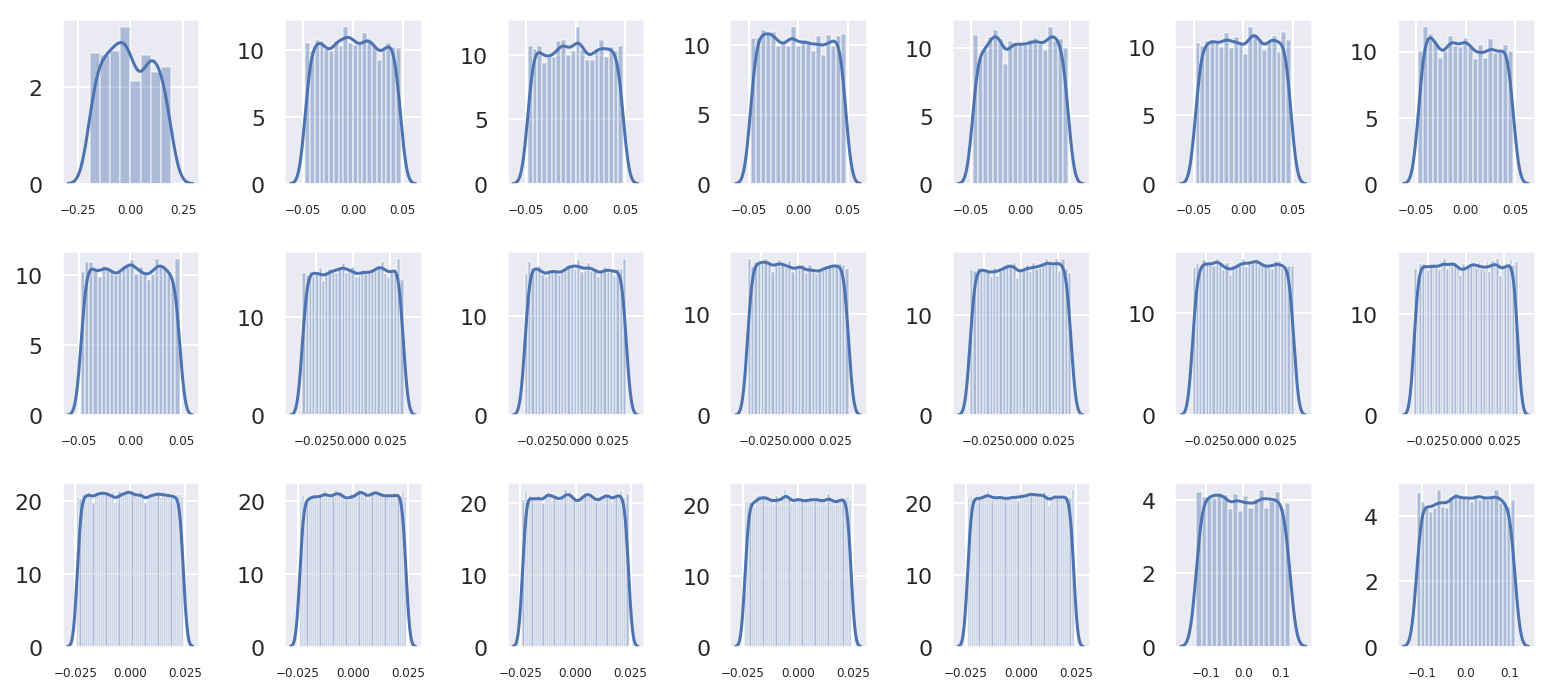

In [0]:
visualization.plot_all_parameters(model_initial)

And this is what they look like after training:

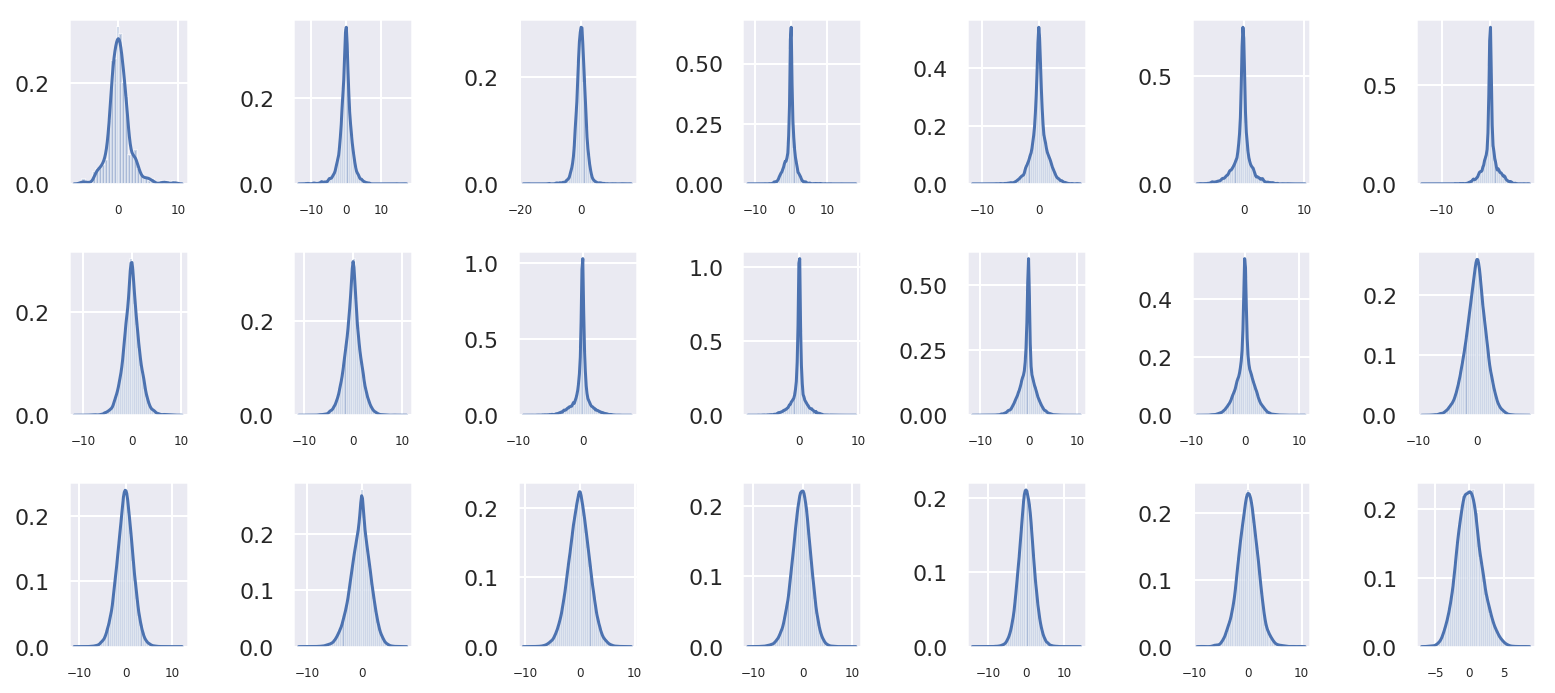

In [0]:
visualization.plot_all_parameters(model_pretrained)

## Testing the model

The last step is to test the PyTorch model. We will preprocess the image according to the configuration file, initialize the reader, sampler and aggregator, run the inference, and verify that results are consistent between NiftyNet and PyTorch.

### Configuration file

```ini
[Modality0]
path_to_search = data/OASIS/
filename_contains = nii
pixdim = (1.0, 1.0, 1.0)
axcodes = (R, A, S)

[NETWORK]
name = highres3dnet
volume_padding_size = 10
whitening = True
normalisation = True
normalise_foreground_only=True
foreground_type = mean_plus
histogram_ref_file = databrain_std_hist_models_otsu.txt
cutoff = (0.001, 0.999)

[INFERENCE]
border = 2
spatial_window_size = (128, 128, 128)
```

We need to match the configuration used during training in order to obtain consistent results. These are the relevant contents of the downloaded [configuration file](https://niftynet.readthedocs.io/en/dev/config_spec.html):

In [0]:
config = ConfigParser()
config.read(config_path);

### Reader

The necessary preprocessing is described in the [paper](https://arxiv.org/abs/1707.01992), [code](https://github.com/NifTK/NiftyNet/blob/61f2a8bbac1348591412c00f55d1c19b91c0367f/niftynet/application/segmentation_application.py#L95-L192) and [configuration file](https://niftynet.readthedocs.io/en/dev/config_spec.html).

NiftyNet offers some powerful I/O tools. We will use its readers, samplers and aggregators to read, preprocess and write all the files. There are multiple [demos in the NiftyNet repository]((https://github.com/NifTK/NiftyNet/tree/dev/demos/module_examples)) that show the usage of these modules.

In [0]:
%%capture
input_dict = dict(
    path_to_search=str(data_dir),
    filename_contains='nii',
    axcodes=('R', 'A', 'S'),
    pixdim=(1, 1, 1),
)
data_parameters = {
    'image': input_dict,
}
reader = ImageReader().initialise(data_parameters)

In [0]:
_, image_data_dict, _ = reader()
original_image = image_data_dict['image']
original_image.shape

(160, 256, 256, 1, 1)

Looking at the shape of our image and knowing that the reader reoriented it into [RAS+ orientation](http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm), we can see that it represents $160$ sagittal slices of $256 \times 256$ pixels, with $1$ channel (monomodal) and $1$ time point. Let's see what it looks like:

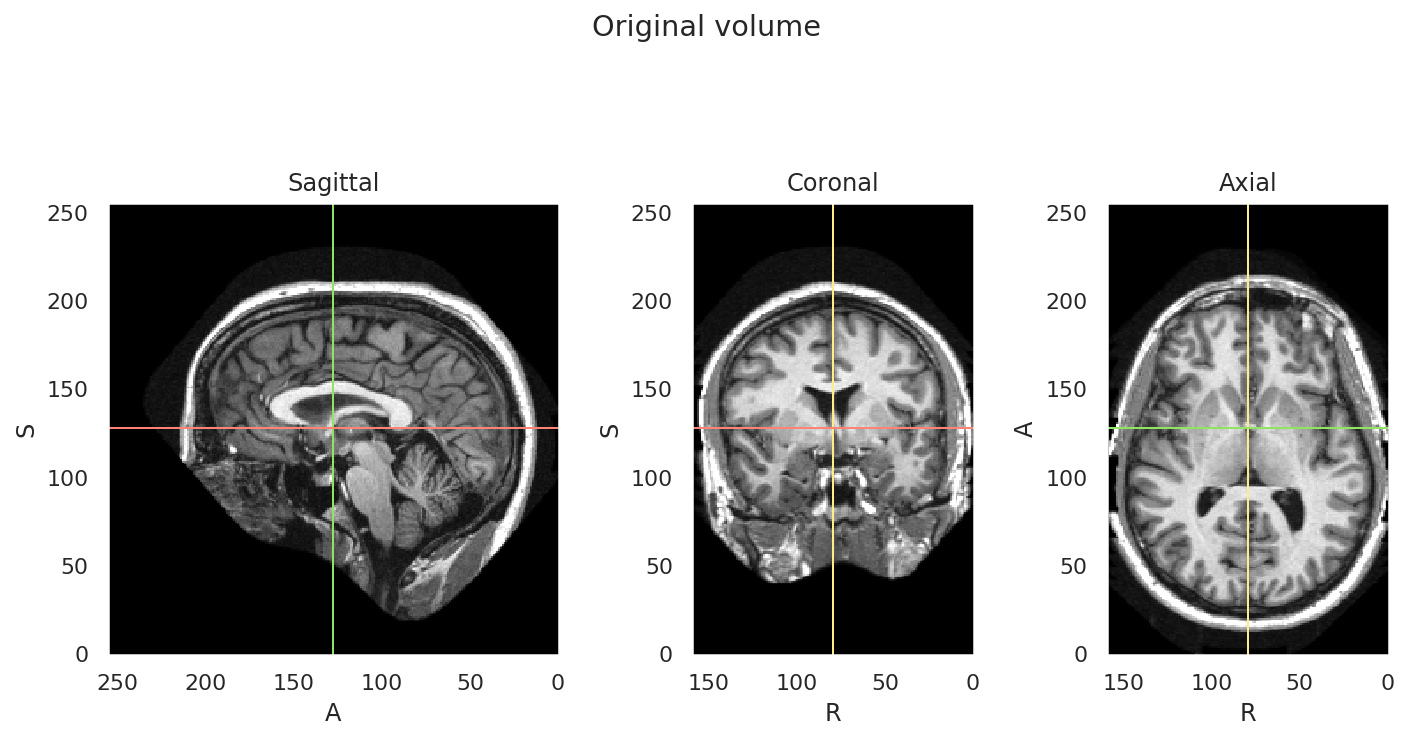

In [0]:
plot_volume(original_image, title='Original volume')

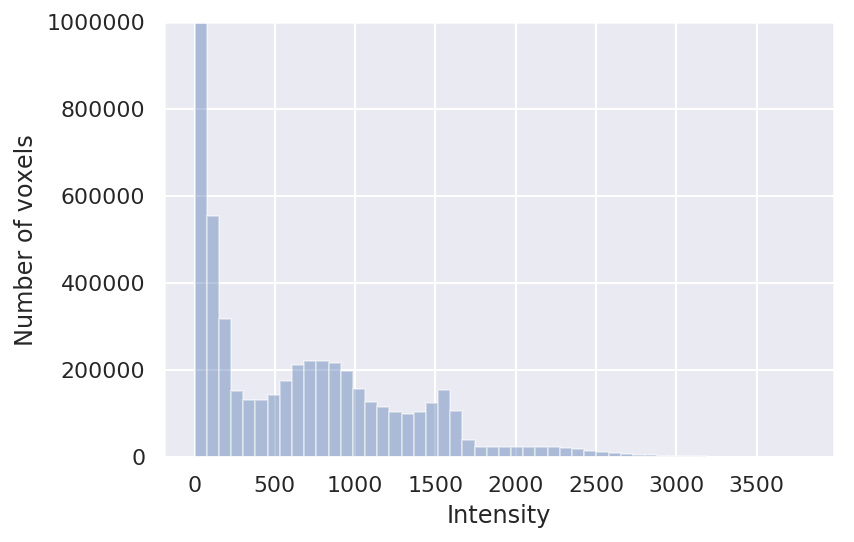

In [0]:
visualization.plot_histogram(original_image, kde=False, add_labels=True, ylim=(0, 1e6))

### Preprocessing

We [pad the input volume](https://niftynet.readthedocs.io/en/dev/window_sizes.html#volume-padding-size) and crop the output volume to reduce the border effect introduced by the padded convolutions:

In [0]:
volume_padding_layer = PadLayer(
    image_name=['image'],  # https://github.com/NifTK/NiftyNet/blob/61f2a8bbac1348591412c00f55d1c19b91c0367f/niftynet/layer/pad.py#L52
    border=(10, 10, 10),
)

We use a masking function in order to use only the foreground voxels for normalization:

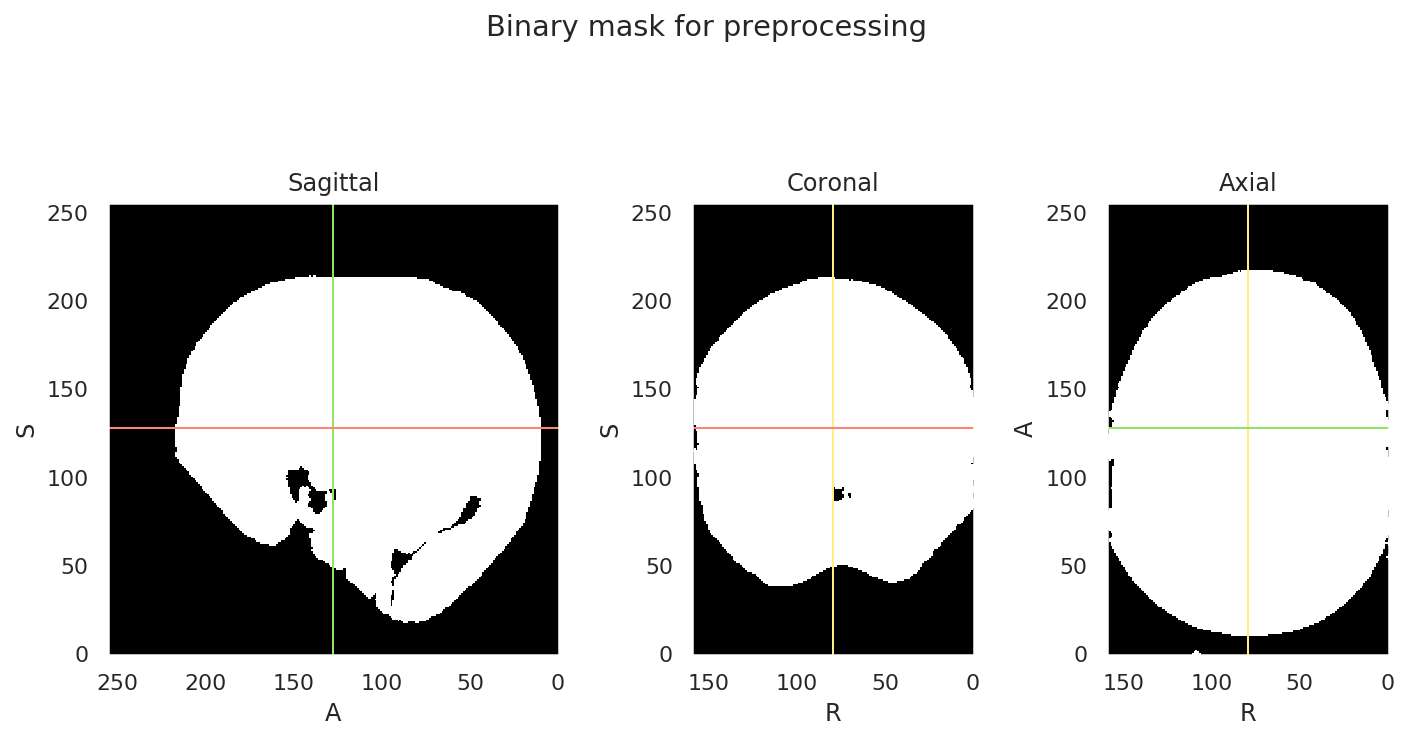

In [0]:
binary_masking_func = BinaryMaskingLayer(type_str=config['NETWORK']['foreground_type'])
mask = binary_masking_func(original_image)
plot_volume(mask, enhance=False, title='Binary mask for preprocessing')

We use [MRI histogram standardization](https://ieeexplore.ieee.org/document/836373) trained on the training dataset for our test image. We use the mean intensity of the volume as a threshold for the mask, as the authors of the method claim that this usually gives good results.

In [0]:
hist_norm = HistogramNormalisationLayer(
    image_name='image',
    modalities=['Modality0'],
    model_filename=str(histogram_landmarks_path),
    binary_masking_func=binary_masking_func,
    cutoff=(0.001, 0.999),
    name='hist_norm_layer',
)

Finally, we force our image foreground to have zero mean and unit variance:

In [0]:
whitening = MeanVarNormalisationLayer(
    image_name='image', binary_masking_func=binary_masking_func)

Here is our preprocessed image:

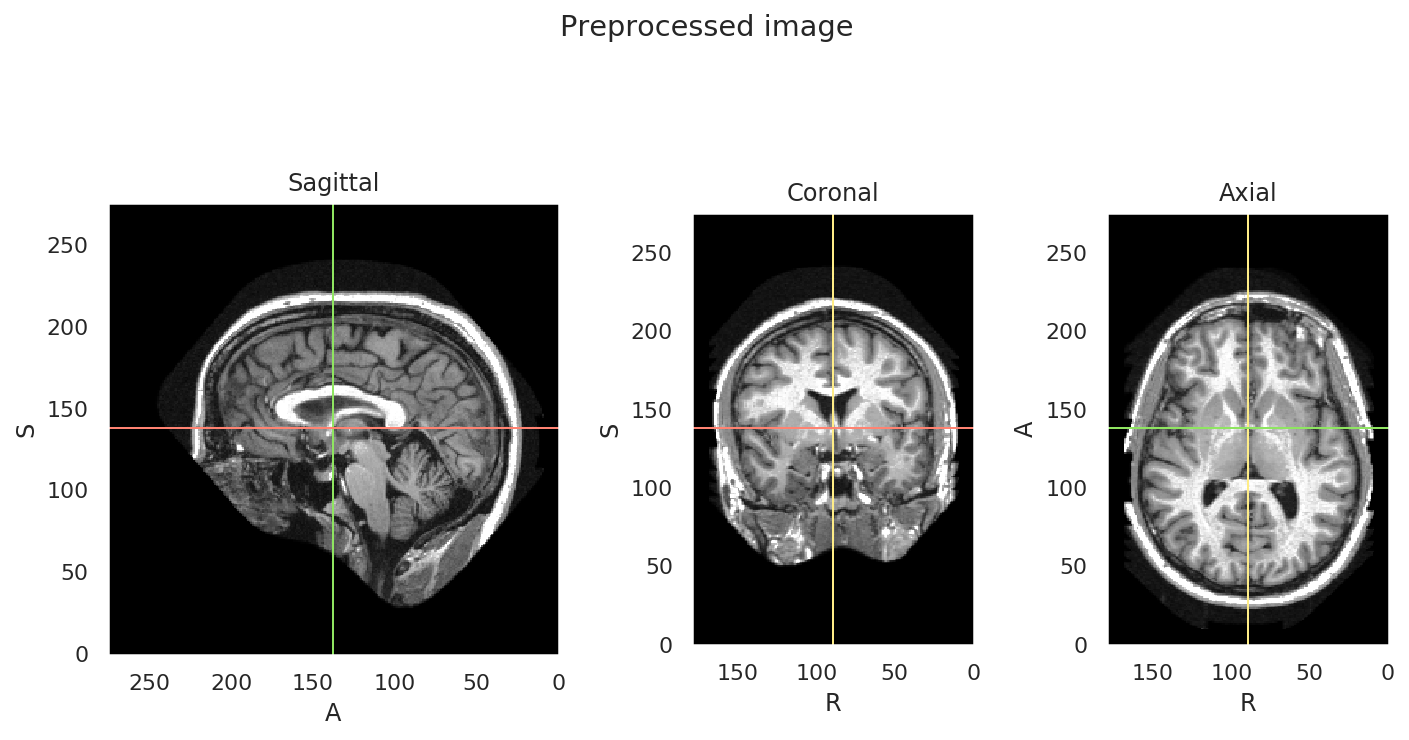

In [0]:
%%capture --no-display
preprocessing_layers = [
    volume_padding_layer,
    hist_norm,
    whitening,
]
reader = ImageReader().initialise(data_parameters)
reader.add_preprocessing_layers(preprocessing_layers)
_, image_data_dict, _ = reader()
preprocessed_image = image_data_dict['image']
plot_volume(preprocessed_image, title='Preprocessed image')

Note the small difference of intensities due to histogram standardization and the 10-voxel zero-padding.

We can clearly see the effect of the whitening layer on the histogram:

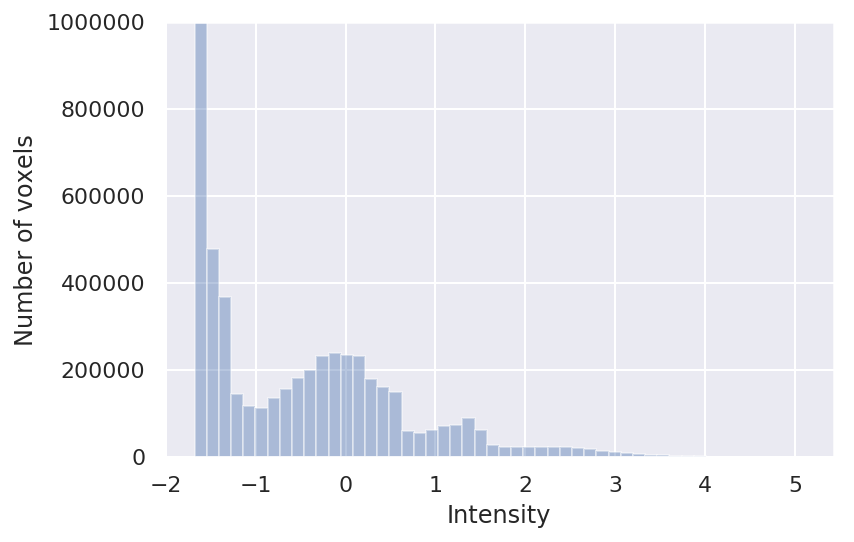

In [0]:
visualization.plot_histogram(preprocessed_image, kde=False, add_labels=True, ylim=(0, 1e6))

### Sampler and aggregator

As the whole image does not fit in most GPUs, we need to use a [patch-based](https://niftynet.readthedocs.io/en/dev/window_sizes.html) approach.

<img src="https://github.com/fepegar/tf2pt/raw/master/images/patch.png" alt="drawing" width="600"/>

We will use NiftyNet's grid sampler to get all windows from the volume (blue in the previous image) and a grid samples aggregator (red) to reconstruct the output image from the inferred windows. If you have any memory issues, try reducing the window size.

The [window border](https://niftynet.readthedocs.io/en/dev/window_sizes.html#border) is needed to reduce the border effect in a dense prediction.

In [0]:
%%capture
window_size = 128
window_size = 3 * (window_size, )
window_border = 2, 2, 2
window_size_dict = {'image': window_size}
batch_size = 1

sampler = GridSampler(
    reader,
    window_size_dict,
    window_border=window_border,
)

prediction_pt_dir = tempdir / 'prediction'
prediction_pt_dir.mkdir(exist_ok=True)
aggregator = GridSamplesAggregator(
    image_reader=reader,
    window_border=window_border,
    output_path=prediction_pt_dir,
)

### Run inference

Now, the most important part: running the parcellation! We will iterate over the windows provided by the grid sampler, pass them through the network and aggregate them to the output volume (this might take a couple of minutes):

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()
for batch_index, batch_dict in enumerate(sampler()):
    print(f'Running inference iteration {batch_index}...')
    input_tensor = tf2pt.niftynet_batch_to_torch_tensor(batch_dict).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
    labels = tf2pt.torch_logits_to_niftynet_labels(logits)
    window_dict = dict(window=labels)
    aggregator.decode_batch(window_dict, batch_dict['image_location'])

# Release GPU memory
del model
del model_pretrained
del input_tensor
del logits
torch.cuda.empty_cache()

I0813 14:24:42.951567 140069650646912 sampler_grid_v2.py:77] grid sampling image sizes: {'image': (180, 276, 276, 1, 1)}
I0813 14:24:42.952928 140069650646912 sampler_grid_v2.py:79] grid sampling window sizes: {'image': (128, 128, 128, 1, 1)}
I0813 14:24:42.953923 140069650646912 sampler_grid_v2.py:87] yielding 27 locations from image


Running inference iteration 0...
Running inference iteration 1...
Running inference iteration 2...
Running inference iteration 3...
Running inference iteration 4...
Running inference iteration 5...
Running inference iteration 6...
Running inference iteration 7...
Running inference iteration 8...
Running inference iteration 9...
Running inference iteration 10...
Running inference iteration 11...
Running inference iteration 12...
Running inference iteration 13...
Running inference iteration 14...
Running inference iteration 15...
Running inference iteration 16...
Running inference iteration 17...
Running inference iteration 18...
Running inference iteration 19...
Running inference iteration 20...
Running inference iteration 21...
Running inference iteration 22...
Running inference iteration 23...
Running inference iteration 24...
Running inference iteration 25...
Running inference iteration 26...
Running inference iteration 27...


W0813 14:28:29.565587 140069650646912 misc_io.py:404] File /tmp/miccai_niftynet_pytorch/prediction/window_OAS1_0145_MR2_mpr_n4_anon_sbj_111_niftynet_out.nii.gz exists, overwriting the file.
I0813 14:28:29.730057 140069650646912 misc_io.py:409] Saved /tmp/miccai_niftynet_pytorch/prediction/window_OAS1_0145_MR2_mpr_n4_anon_sbj_111_niftynet_out.nii.gz


Let's [run the inference using NiftyNet](https://github.com/NifTK/NiftyNetModelZoo/tree/5-reorganising-with-lfs/highres3dnet_brain_parcellation#generating-segmentations-for-example-data) as well, so that we can compare both results (this step will also take a couple of minutes):

In [0]:
%run NiftyNet/net_segment.py inference -c ~/niftynet/extensions/highres3dnet_brain_parcellation/highres3dnet_config_eval.ini

NiftyNet version 0+untagged.1.g27cb337
[CUSTOM]
-- num_classes: 160
-- output_prob: False
-- label_normalisation: False
-- softmax: True
-- min_sampling_ratio: 0
-- compulsory_labels: (0, 1)
-- rand_samples: 0
-- min_numb_labels: 1
-- proba_connect: True
-- evaluation_units: foreground
-- label: ()
-- image: ('Modality0',)
-- weight: ()
-- sampler: ()
-- inferred: ()
-- name: net_segment
[CONFIG_FILE]
-- path: /root/niftynet/extensions/highres3dnet_brain_parcellation/highres3dnet_config_eval.ini
[MODALITY0]
-- csv_file: 
-- path_to_search: data/OASIS/
-- filename_contains: ('nii',)
-- filename_not_contains: ()
-- filename_removefromid: 
-- interp_order: 0
-- loader: None
-- pixdim: (1.0, 1.0, 1.0)
-- axcodes: ('R', 'A', 'S')
-- spatial_window_size: (96, 96, 96)
[SYSTEM]
-- cuda_devices: ""
-- num_threads: 2
-- num_gpus: 1
-- model_dir: /root/niftynet/models/highres3dnet_brain_parcellation
-- dataset_split_file: ./dataset_split.csv
-- event_handler: ('model_saver', 'model_restorer', 'sa

I0813 14:28:30.316154 140069650646912 segmentation_application.py:43] starting segmentation application


INFO:niftynet: `csv_file = ` not found, writing to "/root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv" instead.


I0813 14:28:30.325320 140069650646912 image_sets_partitioner.py:266] `csv_file = ` not found, writing to "/root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv" instead.


INFO:niftynet: Overwriting existing: "/root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv".


I0813 14:28:30.335708 140069650646912 image_sets_partitioner.py:269] Overwriting existing: "/root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv".


INFO:niftynet: [Modality0] search file folders, writing csv file /root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv


I0813 14:28:30.337655 140069650646912 image_sets_partitioner.py:286] [Modality0] search file folders, writing csv file /root/niftynet/models/highres3dnet_brain_parcellation/Modality0.csv


INFO:niftynet: 

Number of subjects 1, input section names: ['subject_id', 'Modality0']
-- using all subjects (without data partitioning).



I0813 14:28:30.345340 140069650646912 image_sets_partitioner.py:90] 

Number of subjects 1, input section names: ['subject_id', 'Modality0']
-- using all subjects (without data partitioning).



INFO:niftynet: Image reader: loading 1 subjects from sections ('Modality0',) as input [image]


I0813 14:28:30.358099 140069650646912 image_reader.py:178] Image reader: loading 1 subjects from sections ('Modality0',) as input [image]


INFO:niftynet: normalisation histogram reference models ready for image:('Modality0',)


I0813 14:28:30.362585 140069650646912 histogram_normalisation.py:109] normalisation histogram reference models ready for image:('Modality0',)


INFO:niftynet: initialised window instance


I0813 14:28:30.399088 140069650646912 sampler_grid_v2.py:53] initialised window instance


INFO:niftynet: initialised grid sampler {'image': (1, 128, 128, 128, 1, 1), 'image_location': (1, 7)}


I0813 14:28:30.400890 140069650646912 sampler_grid_v2.py:54] initialised grid sampler {'image': (1, 128, 128, 128, 1, 1), 'image_location': (1, 7)}


INFO:niftynet: using HighRes3DNet


I0813 14:28:30.415297 140069650646912 base_net.py:29] using HighRes3DNet


W0813 14:28:30.419842 140069650646912 deprecation_wrapper.py:119] From NiftyNet/niftynet/application/base_application.py:203: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



INFO:niftynet: Initialising dataset from generator...


I0813 14:28:30.429003 140069650646912 image_window_dataset.py:318] Initialising dataset from generator...


W0813 14:28:30.758420 140069650646912 deprecation_wrapper.py:119] From NiftyNet/niftynet/layer/convolution.py:89: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



W0813 14:28:30.817812 140069650646912 deprecation_wrapper.py:119] From NiftyNet/niftynet/layer/bn.py:75: The name tf.add_to_collection is deprecated. Please use tf.compat.v1.add_to_collection instead.



W0813 14:28:32.201583 140069650646912 deprecation_wrapper.py:119] From NiftyNet/niftynet/engine/application_variables.py:188: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



W0813 14:28:32.212332 140069650646912 deprecation_wrapper.py:119] From NiftyNet/niftynet/engine/handler_model.py:157: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



INFO:niftynet: Restoring parameters from /root/niftynet/models/highres3dnet_brain_parcellation/models/model.ckpt-33000


I0813 14:28:32.514895 140069650646912 saver.py:1280] Restoring parameters from /root/niftynet/models/highres3dnet_brain_parcellation/models/model.ckpt-33000


INFO:niftynet: grid sampling image sizes: {'image': (180, 276, 276, 1, 1)}


I0813 14:28:35.491694 140063852078848 sampler_grid_v2.py:77] grid sampling image sizes: {'image': (180, 276, 276, 1, 1)}


INFO:niftynet: grid sampling window sizes: {'image': (128, 128, 128, 1, 1)}


I0813 14:28:35.497957 140063852078848 sampler_grid_v2.py:79] grid sampling window sizes: {'image': (128, 128, 128, 1, 1)}


INFO:niftynet: yielding 27 locations from image


I0813 14:28:35.504768 140063852078848 sampler_grid_v2.py:87] yielding 27 locations from image


INFO:niftynet: inference iter 0,  (6.849758s)


I0813 14:28:40.225888 140069650646912 handler_console.py:40] inference iter 0,  (6.849758s)


INFO:niftynet: inference iter 1,  (1.398228s)


I0813 14:28:41.633691 140069650646912 handler_console.py:40] inference iter 1,  (1.398228s)


INFO:niftynet: inference iter 2,  (1.405183s)


I0813 14:28:43.044345 140069650646912 handler_console.py:40] inference iter 2,  (1.405183s)


INFO:niftynet: inference iter 3,  (1.404656s)


I0813 14:28:44.455575 140069650646912 handler_console.py:40] inference iter 3,  (1.404656s)


INFO:niftynet: inference iter 4,  (1.411152s)


I0813 14:28:45.872193 140069650646912 handler_console.py:40] inference iter 4,  (1.411152s)


INFO:niftynet: inference iter 5,  (1.404927s)


I0813 14:28:47.286301 140069650646912 handler_console.py:40] inference iter 5,  (1.404927s)


INFO:niftynet: inference iter 6,  (1.417205s)


I0813 14:28:48.709184 140069650646912 handler_console.py:40] inference iter 6,  (1.417205s)


INFO:niftynet: inference iter 7,  (1.411827s)


I0813 14:28:50.129684 140069650646912 handler_console.py:40] inference iter 7,  (1.411827s)


INFO:niftynet: inference iter 8,  (1.413563s)


I0813 14:28:51.558167 140069650646912 handler_console.py:40] inference iter 8,  (1.413563s)


INFO:niftynet: inference iter 9,  (1.412378s)


I0813 14:28:52.979267 140069650646912 handler_console.py:40] inference iter 9,  (1.412378s)


INFO:niftynet: inference iter 10,  (1.423142s)


I0813 14:28:54.408238 140069650646912 handler_console.py:40] inference iter 10,  (1.423142s)


INFO:niftynet: inference iter 11,  (1.422653s)


I0813 14:28:55.836916 140069650646912 handler_console.py:40] inference iter 11,  (1.422653s)


INFO:niftynet: inference iter 12,  (1.418351s)


I0813 14:28:57.261485 140069650646912 handler_console.py:40] inference iter 12,  (1.418351s)


INFO:niftynet: inference iter 13,  (1.430317s)


I0813 14:28:58.697960 140069650646912 handler_console.py:40] inference iter 13,  (1.430317s)


INFO:niftynet: inference iter 14,  (1.426548s)


I0813 14:29:00.131487 140069650646912 handler_console.py:40] inference iter 14,  (1.426548s)


INFO:niftynet: inference iter 15,  (1.420792s)


I0813 14:29:01.562730 140069650646912 handler_console.py:40] inference iter 15,  (1.420792s)


INFO:niftynet: inference iter 16,  (1.435086s)


I0813 14:29:03.006553 140069650646912 handler_console.py:40] inference iter 16,  (1.435086s)


INFO:niftynet: inference iter 17,  (1.432185s)


I0813 14:29:04.444326 140069650646912 handler_console.py:40] inference iter 17,  (1.432185s)


INFO:niftynet: inference iter 18,  (1.425949s)


I0813 14:29:05.878195 140069650646912 handler_console.py:40] inference iter 18,  (1.425949s)


INFO:niftynet: inference iter 19,  (1.429545s)


I0813 14:29:07.317273 140069650646912 handler_console.py:40] inference iter 19,  (1.429545s)


INFO:niftynet: inference iter 20,  (1.426362s)


I0813 14:29:08.754016 140069650646912 handler_console.py:40] inference iter 20,  (1.426362s)


INFO:niftynet: inference iter 21,  (1.431822s)


I0813 14:29:10.194228 140069650646912 handler_console.py:40] inference iter 21,  (1.431822s)


INFO:niftynet: inference iter 22,  (1.438208s)


I0813 14:29:11.638133 140069650646912 handler_console.py:40] inference iter 22,  (1.438208s)


INFO:niftynet: inference iter 23,  (1.433307s)


I0813 14:29:13.080363 140069650646912 handler_console.py:40] inference iter 23,  (1.433307s)


INFO:niftynet: inference iter 24,  (1.428715s)


I0813 14:29:14.518631 140069650646912 handler_console.py:40] inference iter 24,  (1.428715s)


INFO:niftynet: inference iter 25,  (1.438985s)


I0813 14:29:15.967192 140069650646912 handler_console.py:40] inference iter 25,  (1.438985s)


INFO:niftynet: inference iter 26,  (1.442692s)


I0813 14:29:17.415152 140069650646912 handler_console.py:40] inference iter 26,  (1.442692s)


W0813 14:29:18.846176 140069650646912 misc_io.py:404] File /root/niftynet/models/highres3dnet_brain_parcellation/parcellation_output/window_seg_OAS1_0145_MR2_mpr_n4_anon_sbj_111__niftynet_out.nii.gz exists, overwriting the file.


INFO:niftynet: Saved /root/niftynet/models/highres3dnet_brain_parcellation/parcellation_output/window_seg_OAS1_0145_MR2_mpr_n4_anon_sbj_111__niftynet_out.nii.gz


I0813 14:29:19.148135 140069650646912 misc_io.py:409] Saved /root/niftynet/models/highres3dnet_brain_parcellation/parcellation_output/window_seg_OAS1_0145_MR2_mpr_n4_anon_sbj_111__niftynet_out.nii.gz


INFO:niftynet: inference iter 27,  (1.425158s)


I0813 14:29:19.155847 140069650646912 handler_console.py:40] inference iter 27,  (1.425158s)


INFO:niftynet: stopping -- event handler: OutputInterpreter.


I0813 14:29:19.159992 140069650646912 application_driver.py:336] stopping -- event handler: OutputInterpreter.


INFO:niftynet: cleaning up...


I0813 14:29:19.166005 140069650646912 application_driver.py:220] cleaning up...


INFO:niftynet: stopping sampling threads


I0813 14:29:19.168484 140069650646912 handler_sampler.py:53] stopping sampling threads


INFO:niftynet: SegmentationApplication stopped (time in second 46.99).


I0813 14:29:19.193871 140069650646912 application_driver.py:232] SegmentationApplication stopped (time in second 46.99).


<Figure size 432x288 with 0 Axes>

### Check results

In [0]:
%%capture
input_image = utils.get_first_array(data_dir)
labels_nn = utils.get_first_array(models_dir).astype(np.uint16)
labels_pt = utils.get_first_array(prediction_pt_dir).astype(np.uint16)

#### Quantitatively

In [0]:
difference = labels_nn != labels_pt
num_different_voxels = np.count_nonzero(difference)
print('Number of different voxels:', num_different_voxels)

Number of different voxels: 0


Success! ✨ Both parcellations are exactly the same.

#### Qualitatively

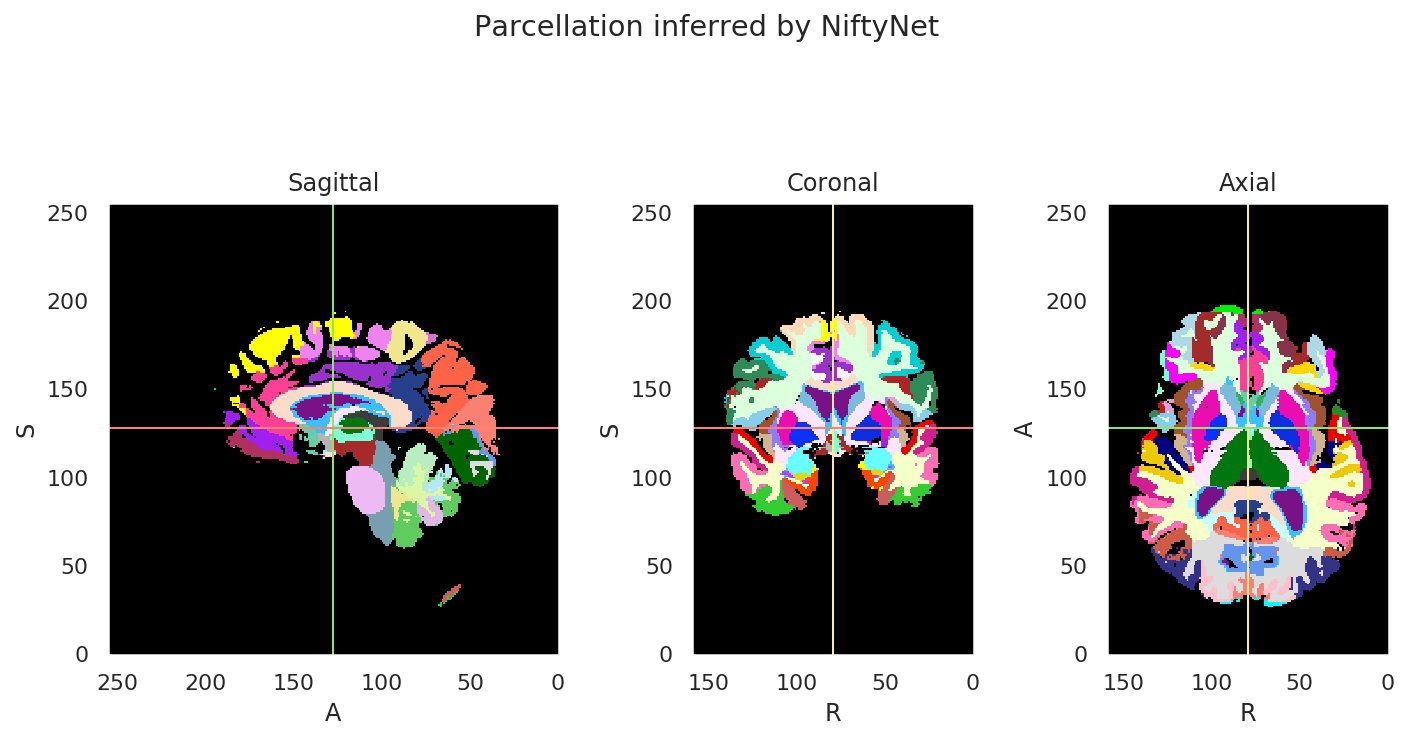

In [0]:
plot_volume(
    labels_nn,
    enhance=False,
    colors_path=color_table_path,
    title='Parcellation inferred by NiftyNet',
)

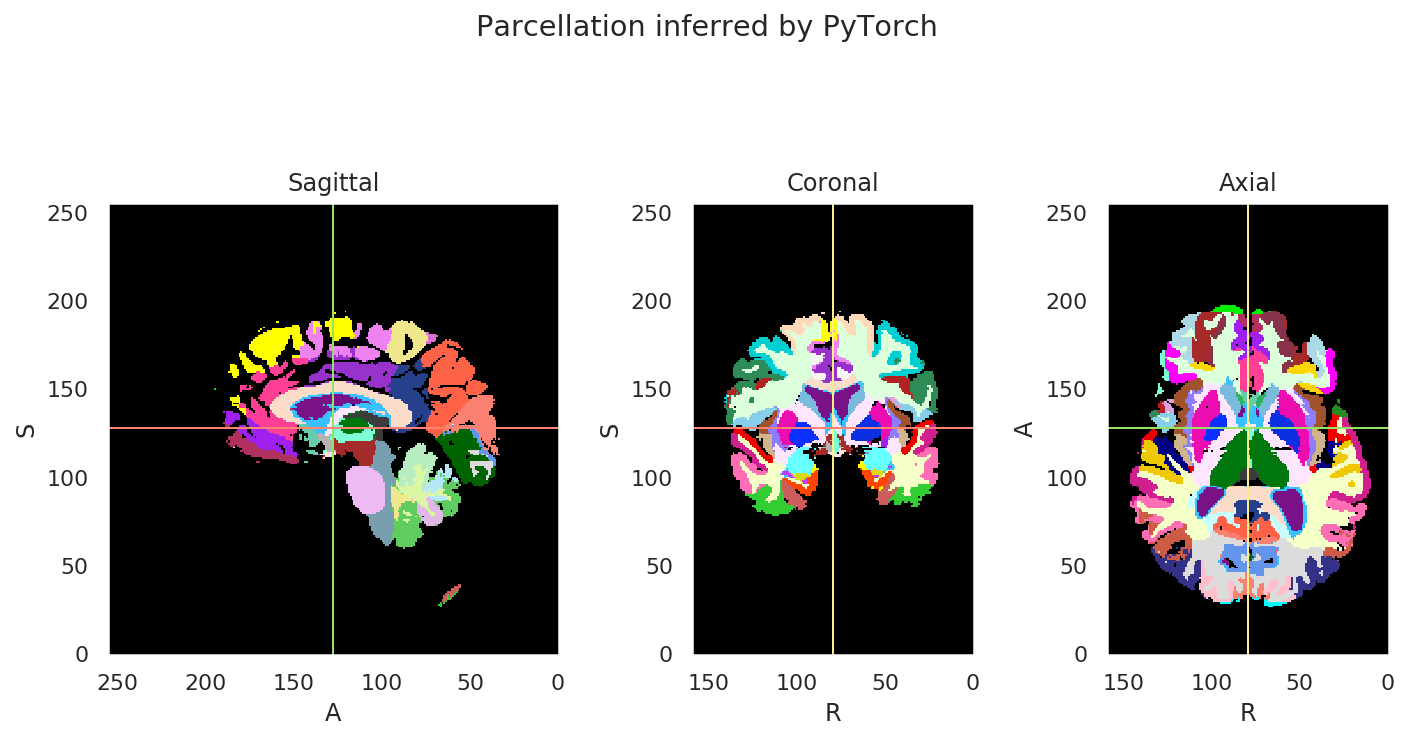

In [0]:
plot_volume(
    labels_pt,
    enhance=False,
    colors_path=color_table_path,
    title='Parcellation inferred by PyTorch',
)

## Conclusion

In this tutorial we have shown how to combine features from two deep learning frameworks, NiftyNet and PyTorch.

We ported a model for brain parcellation from NiftyNet to PyTorch and ran an inference using a PyTorch model and NiftyNet I/O capabilities.

## Acknowledgments

I want to thank Pritesh Mehta, Tom Varsavsky, Zach Eaton-Rosen and Oeslle Lucena for their feedback.

If you want to cite this tutorial you can use this [Zenodo DOI](https://doi.org/10.5281/zenodo.3352316):

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3352316.svg)](https://doi.org/10.5281/zenodo.3352316)